<a href="https://colab.research.google.com/github/anushapv2000/Final-YEAR/blob/main/anime_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Animegan without transfer learning


In [ ]:
import tensorflow as tf

In [ ]:
!sudo mkdir /content/onedrive
!nohup rclone — vfs-cache-mode writes mount onedrive: /content/onedrive &

nohup: appending output to 'nohup.out'


In [ ]:
!pip install pytorch-lightning

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import os
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
#import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR ='/content/drive/MyDrive/Documents/DOWNLOADS'
print(len(os.listdir(DATA_DIR )))

1


In [ ]:
#DATA_DIR = '/content/drive/Othercomputers/My Laptop/Documents/Python Scripts/cropped_3'
#print(len(os.listdir(DATA_DIR )))

In [ ]:
os.listdir(DATA_DIR)

['cropped_3']

In [ ]:
cp -r  '/content/drive/Othercomputers/My Laptop/Documents/Python Scripts/cropped_3' '/content/images'

cp: cannot stat '/content/drive/Othercomputers/My Laptop/Documents/Python Scripts/cropped_3': No such file or directory


In [ ]:
DATA_DIR='/content/images/'

In [ ]:
rm -rvf /content/cropped/.ipynb_checkpoints

removed directory '/content/cropped/.ipynb_checkpoints'


In [ ]:
print(os.listdir(DATA_DIR ))

In [ ]:
image_size=64
batch_size=128
stats=((0.5,0.5,0.5),(0.5,0.5,0.5))

In [ ]:
#@title
train_ds = ImageFolder(DATA_DIR, transform= T.Compose([
            T.Resize(image_size),
            T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(*stats)
]))
train_dl = DataLoader(train_ds, batch_size , shuffle=True,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(train_ds)

15489

In [ ]:
for i ,l in train_ds:
  print(i.shape)
  break

torch.Size([3, 64, 64])


In [ ]:

#@title
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return images * stds + means

def show_batch(dl):
    #for images, labels in dl:
        #print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(dl, *stats)
        ax.imshow(make_grid(denorm_images[:32], nrow=8).permute(1,2,0))
     #   break

In [ ]:

#@title
def denormalize(images, means, stds):
    images=images.to('cpu')
    means = torch.tensor(means).reshape(1, 3, 1, 1).to('cpu')
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to('cpu')
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        #print(images.shape)
        #dl=images.unsqueeze(0)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images.detach(), *stats)
        ax.imshow(make_grid(denorm_images[:32], nrow=8).permute(1,2,0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


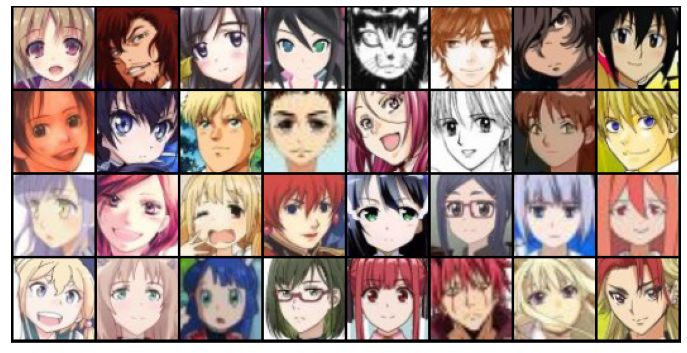

In [ ]:

show_batch(train_dl)


In [ ]:

#@title
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
      return len(self.dl)

# anime-gan

Use the "Run" button to execute the code.

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)

In [ ]:
import torch.nn as nn


In [ ]:


discriminator = nn.Sequential(
    
  nn.Conv2d(3,64,kernel_size=4, stride = 2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.2,inplace=True),
  
  nn.Conv2d(64,128,kernel_size=4, stride = 2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2,inplace=True),

  nn.Conv2d(128,256,kernel_size=4, stride = 2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.LeakyReLU(0.2,inplace=True),

  nn.Conv2d(256,512,kernel_size=4, stride = 2, padding=1, bias=False),
  nn.BatchNorm2d(512),
  nn.LeakyReLU(0.2,inplace=True),

  nn.Conv2d(512,1,kernel_size=4, stride = 1, padding=0, bias=False),
  nn.Flatten(),
  nn.Sigmoid()

)

In [ ]:
print(discriminator.parameters)

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1

In [ ]:
model = to_device(discriminator, device)
model


Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [ ]:
latent_size=128

In [ ]:
generator=nn.Sequential(
          nn.ConvTranspose2d(latent_size, 512, kernel_size=4,stride =1, padding=0,bias=False), 
          nn.BatchNorm2d(512), 
          nn.ReLU(True),

          nn.ConvTranspose2d(512,256, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.BatchNorm2d(256), 
          nn.ReLU(True),

          nn.ConvTranspose2d(256,128, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.BatchNorm2d(128), 
          nn.ReLU(True),

          nn.ConvTranspose2d(128,64, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.BatchNorm2d(64), 
          nn.ReLU(True),

          nn.ConvTranspose2d(64,3, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.Tanh()
)


In [ ]:
generator=to_device(generator,device)

In [ ]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
xb=torch.randn(2,latent_size,1,1,device=device)

In [ ]:
xb.shape

torch.Size([2, 128, 1, 1])

In [ ]:
fake_img = generator(xb)
print(fake_img.shape)
#show_batch(fake_img)

In [ ]:
def tr_discrim(real_images,opt_d):
  opt_d.zero_grad()

  #Pass real images through discriminator
  real_preds = discriminator (real_images)
  real_targets = torch.ones (real_images. size (0) , 1, device=device )
  real_loss = F.binary_cross_entropy (real_preds, real_targets)
  real_score = torch.mean(real_preds). item ()
  #Generate fake images
  latent =  torch.randn (batch_size, latent_size, 1, 1, device=device )
  fake_images = generator( latent)
  #Pass fake images through discriminator
  fake_targets= torch.zeros(fake_images. size (0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy ( fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()
  
  loss = real_loss+fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
#Because of this, when you start your training loop, ideally you
#should zero out the gradients so that you do the parameter update 
#correctly. Otherwise, the gradient would be a combination of the old 
#gradient, which you have already used to update your model parameters,
# and the newly-computed gradient. It would therefore point in some 
#other direction than the intended direction towards the minimum 
#(or maximum, in case of maximization objectives).
def tr_generator(opt_g):
  opt_g.zero_grad()
  latent = torch.randn(batch_size, latent_size, 1,1 , device=device)
  fake_imgs =  generator(latent)

  fool_discrim_preds = discriminator(fake_imgs)
  fool_discrim_target = torch.ones(batch_size,1, device=device)
  loss = F.binary_cross_entropy(fool_discrim_preds,fool_discrim_target)

  loss.backward()
  opt_g.step()
  return loss.item()
  

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'

os.makedirs(sample_dir,exist_ok=True)

In [ ]:

def save_generated(index,latent_tensors,show=True):
  fake_imgs = generator(latent_tensors)
  fake_label = 'img_generated-{0:0=4d}.png'.format(index) 
  save_image(denormalize(fake_imgs,*stats),os.path.join(sample_dir,fake_label),nrow=8)
  if show:
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_imgs.cpu().detach(),nrow=8).permute(1,2,0))


In [ ]:
fake_imgs = generator(xb)

In [ ]:
fake_label = 'img_generated-{0:0=4d}.png'.format(1)

In [ ]:
save_image(denormalize(fake_imgs,*stats),os.path.join(sample_dir,fake_label),nrow=8)

In [ ]:
xr = torch.randn(64, latent_size, 1,1,device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


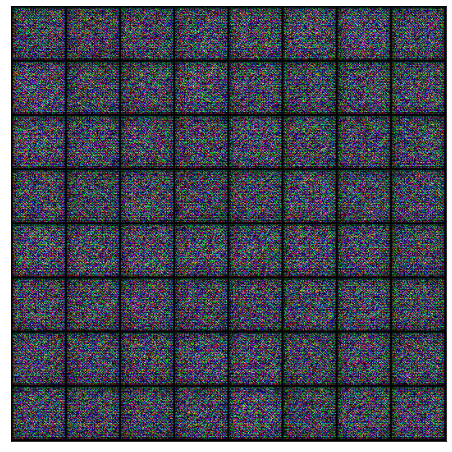

In [ ]:
save_generated(0,xr)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
import time

In [ ]:
def fit(epochs, lr, start_idx=1):
   torch.cuda.empty_cache()

   losses_g = []
   losses_d = []
   real_scores = []
   fake_scores = []

   opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr, betas = (0.5, 0.999))
   opt_g = torch.optim.Adam(generator.parameters(),lr=lr , betas = (0.5,0.999))
   t1=time.time()
   for epoch in range(epochs):
     for real_images, _ in tqdm(train_dl):
       loss_d , real_score, fake_score = tr_discrim(real_images, opt_d)
       loss_g = tr_generator(opt_g)
     
     losses_g.append(loss_g)
     losses_d.append(loss_d)
     real_scores.append(real_score)
     fake_scores.append(fake_score)
      
     print("Epoch[{}/{}], loss_g:{:.4f}, loss_d:{:.4f},real_score:{:.4f}, fake_score:{:.4f} ".format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))
     
     save_generated(epoch+start_idx,xr,show=False)
   t2=time.time()
   print("time taken",t2-t1)
   return losses_g,  real_scores, fake_scores ,losses_d,

In [ ]:
lr = 0.0002
epochs = 100
#metric_values=[]

In [ ]:
metric_values_100=metric_values

In [ ]:
metric_values.append( fit(epochs, lr))

  0%|          | 0/122 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[1/100], loss_g:4.7629, loss_d:0.3255,real_score:0.7465, fake_score:0.0310 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[2/100], loss_g:5.3341, loss_d:0.0245,real_score:0.9999, fake_score:0.0233 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[3/100], loss_g:5.7923, loss_d:0.0498,real_score:0.9555, fake_score:0.0043 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[4/100], loss_g:0.0032, loss_d:0.5723,real_score:0.5799, fake_score:0.0249 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[5/100], loss_g:0.0034, loss_d:6.3955,real_score:0.0019, fake_score:0.0953 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[6/100], loss_g:7.1501, loss_d:0.0053,real_score:1.0000, fake_score:0.0052 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[7/100], loss_g:0.0000, loss_d:9.8438,real_score:0.0001, fake_score:0.0155 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[8/100], loss_g:6.1323, loss_d:0.0619,real_score:0.9875, fake_score:0.0473 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[9/100], loss_g:7.1573, loss_d:0.0056,real_score:0.9981, fake_score:0.0037 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[10/100], loss_g:5.6592, loss_d:0.0246,real_score:0.9943, fake_score:0.0185 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[11/100], loss_g:6.1178, loss_d:0.1010,real_score:0.9951, fake_score:0.0882 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[12/100], loss_g:7.8179, loss_d:0.0253,real_score:0.9838, fake_score:0.0089 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[13/100], loss_g:5.1944, loss_d:0.0180,real_score:1.0000, fake_score:0.0175 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[14/100], loss_g:6.2149, loss_d:0.0431,real_score:0.9983, fake_score:0.0396 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[15/100], loss_g:5.8235, loss_d:0.0770,real_score:0.9641, fake_score:0.0379 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[16/100], loss_g:1.1272, loss_d:4.1937,real_score:0.0151, fake_score:0.0000 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[17/100], loss_g:2.8938, loss_d:0.6135,real_score:0.7526, fake_score:0.2218 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[18/100], loss_g:0.6200, loss_d:1.6960,real_score:0.2559, fake_score:0.2701 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[19/100], loss_g:5.2911, loss_d:0.0207,real_score:0.9994, fake_score:0.0197 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[20/100], loss_g:0.3036, loss_d:1.0016,real_score:0.4521, fake_score:0.1668 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[21/100], loss_g:1.0434, loss_d:0.3432,real_score:0.7200, fake_score:0.0143 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[22/100], loss_g:2.2095, loss_d:0.2100,real_score:0.8341, fake_score:0.0263 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[23/100], loss_g:10.8001, loss_d:0.0123,real_score:1.0000, fake_score:0.0103 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[24/100], loss_g:5.5523, loss_d:0.0565,real_score:1.0000, fake_score:0.0535 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[25/100], loss_g:0.0005, loss_d:3.4870,real_score:0.0314, fake_score:0.0247 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[26/100], loss_g:6.0928, loss_d:0.0333,real_score:0.9902, fake_score:0.0228 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[27/100], loss_g:0.0000, loss_d:17.4202,real_score:0.0000, fake_score:0.0136 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[28/100], loss_g:0.0004, loss_d:2.0576,real_score:0.1341, fake_score:0.0461 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[29/100], loss_g:0.0008, loss_d:9.9281,real_score:0.0000, fake_score:0.0013 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[30/100], loss_g:5.5794, loss_d:0.0231,real_score:1.0000, fake_score:0.0227 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[31/100], loss_g:0.0000, loss_d:2.9800,real_score:0.0547, fake_score:0.0693 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[32/100], loss_g:1.2481, loss_d:0.4569,real_score:0.6467, fake_score:0.0204 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[33/100], loss_g:0.0004, loss_d:5.5286,real_score:0.0040, fake_score:0.0054 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[34/100], loss_g:5.1010, loss_d:0.1084,real_score:0.9353, fake_score:0.0404 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[35/100], loss_g:0.1284, loss_d:1.7204,real_score:0.1881, fake_score:0.0445 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[36/100], loss_g:5.7541, loss_d:0.0730,real_score:0.9999, fake_score:0.0680 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[37/100], loss_g:6.9496, loss_d:0.0214,real_score:0.9918, fake_score:0.0128 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[38/100], loss_g:8.3310, loss_d:0.0093,real_score:0.9991, fake_score:0.0084 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[39/100], loss_g:0.1366, loss_d:9.7789,real_score:0.0001, fake_score:0.0034 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[40/100], loss_g:13.0460, loss_d:0.6298,real_score:0.9290, fake_score:0.3946 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[41/100], loss_g:2.8368, loss_d:0.1780,real_score:0.8741, fake_score:0.0416 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[42/100], loss_g:0.0004, loss_d:15.0775,real_score:0.0000, fake_score:0.0077 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[43/100], loss_g:0.0005, loss_d:2.0191,real_score:0.1413, fake_score:0.0589 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[44/100], loss_g:8.8892, loss_d:0.0090,real_score:0.9940, fake_score:0.0030 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[45/100], loss_g:0.0127, loss_d:1.0959,real_score:0.3448, fake_score:0.0298 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[46/100], loss_g:0.0001, loss_d:3.4826,real_score:0.0308, fake_score:0.0023 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[47/100], loss_g:6.2762, loss_d:0.0207,real_score:1.0000, fake_score:0.0194 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[48/100], loss_g:1.4025, loss_d:0.1403,real_score:0.9013, fake_score:0.0346 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[49/100], loss_g:8.7449, loss_d:0.2621,real_score:0.9943, fake_score:0.1978 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[50/100], loss_g:7.6026, loss_d:0.1222,real_score:0.9844, fake_score:0.0927 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[51/100], loss_g:14.3682, loss_d:4.3076,real_score:0.0135, fake_score:0.0000 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[52/100], loss_g:0.0000, loss_d:4.8365,real_score:0.0100, fake_score:0.1845 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[53/100], loss_g:0.2921, loss_d:0.8208,real_score:0.4630, fake_score:0.0486 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[54/100], loss_g:0.0006, loss_d:2.3827,real_score:0.1022, fake_score:0.0942 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[55/100], loss_g:0.0008, loss_d:4.3779,real_score:0.0126, fake_score:0.0032 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[56/100], loss_g:5.7812, loss_d:0.1008,real_score:0.9994, fake_score:0.0925 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[57/100], loss_g:0.0010, loss_d:2.0475,real_score:0.1442, fake_score:0.1002 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[58/100], loss_g:0.0271, loss_d:1.0647,real_score:0.3642, fake_score:0.0508 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[59/100], loss_g:0.0096, loss_d:4.4073,real_score:0.0125, fake_score:0.0240 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[60/100], loss_g:4.3465, loss_d:0.0937,real_score:0.9352, fake_score:0.0255 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[61/100], loss_g:1.8708, loss_d:0.2853,real_score:0.7905, fake_score:0.0476 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[62/100], loss_g:5.7948, loss_d:0.1792,real_score:0.9514, fake_score:0.1108 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[63/100], loss_g:6.7161, loss_d:0.1242,real_score:1.0000, fake_score:0.1081 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[64/100], loss_g:0.0021, loss_d:10.5531,real_score:0.0000, fake_score:0.0326 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[65/100], loss_g:0.0000, loss_d:9.8973,real_score:0.0001, fake_score:0.0110 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[66/100], loss_g:0.0003, loss_d:3.6838,real_score:0.0267, fake_score:0.0570 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[67/100], loss_g:0.0000, loss_d:5.5795,real_score:0.0042, fake_score:0.0912 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[68/100], loss_g:0.0020, loss_d:8.7202,real_score:0.0002, fake_score:0.0712 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[69/100], loss_g:6.4082, loss_d:0.0303,real_score:0.9985, fake_score:0.0273 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[70/100], loss_g:0.4869, loss_d:0.3986,real_score:0.7148, fake_score:0.0588 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[71/100], loss_g:6.1415, loss_d:0.0648,real_score:0.9830, fake_score:0.0437 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[72/100], loss_g:5.8777, loss_d:0.1833,real_score:0.9851, fake_score:0.1469 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[73/100], loss_g:7.6603, loss_d:0.0144,real_score:0.9968, fake_score:0.0106 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[74/100], loss_g:1.5879, loss_d:0.1980,real_score:0.8561, fake_score:0.0376 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[75/100], loss_g:0.0022, loss_d:4.0594,real_score:0.0179, fake_score:0.0377 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[76/100], loss_g:13.9580, loss_d:0.6915,real_score:0.9916, fake_score:0.3303 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[77/100], loss_g:1.1093, loss_d:0.4467,real_score:0.6429, fake_score:0.0049 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[78/100], loss_g:2.0015, loss_d:0.2799,real_score:0.8332, fake_score:0.0748 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[79/100], loss_g:0.0099, loss_d:2.0796,real_score:0.1380, fake_score:0.0847 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[80/100], loss_g:6.3865, loss_d:0.0294,real_score:0.9891, fake_score:0.0177 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[81/100], loss_g:0.0271, loss_d:2.0866,real_score:0.1261, fake_score:0.0158 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[82/100], loss_g:0.4056, loss_d:0.3395,real_score:0.7221, fake_score:0.0136 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[83/100], loss_g:4.8995, loss_d:0.0742,real_score:1.0000, fake_score:0.0671 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[84/100], loss_g:0.0352, loss_d:3.5073,real_score:0.0321, fake_score:0.0615 


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch[85/100], loss_g:3.1351, loss_d:0.0971,real_score:0.9646, fake_score:0.0502 


  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
files.download('/content/generated') 

In [ ]:
!zip -r /content/generated.zip /content/generated

RESNET


In [ ]:
import torchvision.transforms as T
img_size = 256
DATA_DIR='/content/drive/Othercomputers/My Laptop/Documents/Python Scripts/cropped_3'
images=os.listdir('/content/drive/Othercomputers/My Laptop/Documents/Python Scripts/cropped_3')
from PIL import Image
def open_image(p):
    with open(p,'rb') as file:
        img=Image.open(file)
        return img.convert('RGB')
plt.imshow(open_image(os.path.join(DATA_DIR,images[4])))
plt.imshow(Image.open(os.path.join(DATA_DIR,images[5])))

In [ ]:
from torch.utils.data import Dataset
class preprocess(Dataset):
    def __init__(self,root,transform):
        super().__init__()
        self.root=root
        self.files = [f for f in os.listdir(root)]
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        f=self.files[i]
        fp=os.path.join(self.root,f)
        img=self.transform(open_image(fp))
        return img

In [ ]:
imagenet_stats =([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#([0.5,0.5,0.5],[0.5,0.5,0.5])
img_size = 256
dataset = preprocess(DATA_DIR,T.Compose ([
T.Resize (img_size),
T.Pad (8, padding_mode='reflect'),
T.CenterCrop(img_size),
T.ToTensor(),
T.Normalize(*imagenet_stats)]))

In [ ]:
def device_available():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.cuda.device('cpu')
def feed_device(data,device):
    if isinstance(data, (list,tuple)):
        return [feed_device(x, device) for x in data]
    return data.to(device,non_blocking = True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield feed_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = device_available()
device

device(type='cuda')

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
def denormalize_gpu(images, means, stds):
    means = torch.tensor(means,device=device).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds,device=device).reshape(1, 3, 1, 1)
    return images * stds + means
def show_image(dl):
    #for images, labels in dl:
    if len(dl.shape)==3:
        dl = dl.unsqueeze(0)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(dl, *imagenet_stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0))
     #   break

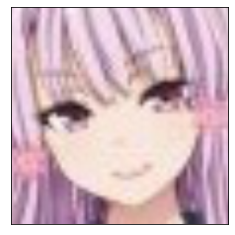

In [ ]:
show_image(dataset[0])

In [ ]:
from torch.utils.data import random_split
val_pct = 0.3
val_size = int(val_pct* len (dataset))
train_ds,valid_ds = random_split ( dataset,[len(dataset) - val_size, val_size ])

In [ ]:

batch_size = 128
train_dl = DataLoader ( train_ds, batch_size, shuffle=True , num_workers=3 , pin_memory=True)
valid_dl= DataLoader (valid_ds , batch_size*2 , num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *imagenet_stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0))
        break
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


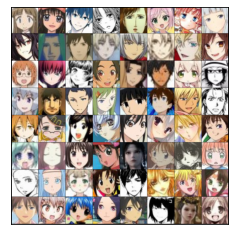

In [ ]:
show_batch(valid_dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch.nn as nn
import torch. nn. functional as F
def accuracy (outputs, labels) :
    preds = torch.max (outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len (preds ) )

class ImageClassificationBase (nn. Module ) :
    def training_step (self, batch) :
        images, labels = batch
        out=self(images)
        loss= F.cross_entropy (out, labels) 
        return loss
    def validate_stop(self, batch):
        valid , _ =batch
        out= self (valid)
        loss = F.cross_entropy (out, _)
        acc = accuracy (out, labels)
        return {'val_loss': loss .detach (), 'val_acc' : acc}


In [ ]:
from torchvision import models
class discriminator(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()
        self.network = models.resnet34(pretrained=pretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features,1)
    def forward(self,xb):
        return self.network(xb)

In [ ]:
resnet=models.resnet34(pretrained=True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:

discriminator = models.resnet34(pretrained=True)
discriminator.fc = nn.Linear(discriminator.fc.in_features,1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#print(discriminator.parameters)
discriminator = feed_device(discriminator, device)

In [ ]:

latent_size=128
generator=nn.Sequential(
          nn.ConvTranspose2d(latent_size, 512, kernel_size=4,stride =1, padding=0,bias=False), 
          nn.BatchNorm2d(512), 
          nn.ReLU(True),

          nn.ConvTranspose2d(512,256, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.BatchNorm2d(256), 
          nn.ReLU(True),

          nn.ConvTranspose2d(256,128, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.BatchNorm2d(128), 
          nn.ReLU(True),

          nn.ConvTranspose2d(128,64, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.BatchNorm2d(64), 
          nn.ReLU(True),

          nn.ConvTranspose2d(64,3, kernel_size=4,stride =2, padding=1,bias=False), 
          nn.Tanh()
)

In [ ]:
generator = to_device(generator, device)

In [ ]:
import numpy as np
def tr_discrim(real_images,opt_d):
    opt_d.zero_grad()

    #Pass real images through discriminator  
    real_preds = discriminator (real_images).cpu().detach().numpy()
    real_preds=(real_preds - np.min(real_preds)) / (np.max(real_preds) - np.min(real_preds))
    real_preds=torch.from_numpy(real_preds).to(device)
    real_preds.requires_grad =True
    real_targets = torch.ones (real_images. size (0) , 1,device=device)
    real_loss = F.binary_cross_entropy (real_preds, real_targets)
    real_score = torch.mean(real_preds). item ()
    #Generate fake images
    latent =  torch.randn (batch_size, latent_size, 1, 1,device=device)
    fake_images = generator( latent)
    #Pass fake images through discriminator
    fake_targets= torch.zeros(fake_images. size (0), 1,device=device)
    fake_preds = discriminator(fake_images).cpu().detach().numpy()
    fake_preds=(fake_preds - np.min(fake_preds)) / (np.max(fake_preds) - np.min(fake_preds))
    fake_preds=torch.from_numpy(fake_preds).to(device)
    fake_loss = F.binary_cross_entropy ( fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def tr_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1,1,device=device )
    fake_imgs =  generator(latent)

    fool_discrim_preds = discriminator(fake_imgs).cpu().detach().numpy()
    fool_discrim_preds=(fool_discrim_preds - np.min(fool_discrim_preds)) / (np.max(fool_discrim_preds) - np.min(fool_discrim_preds))
    fool_discrim_preds=torch.from_numpy(fool_discrim_preds).to(device)
    fool_discrim_preds.requires_grad=True
    fool_discrim_target = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(fool_discrim_preds,fool_discrim_target)

    loss.backward()
    opt_g.step()
    return loss.item()

In [ ]:
sample_dir = 'generated_65_resnet'
os.makedirs(sample_dir,exist_ok=True)

In [ ]:
def save_generated(index,latent_tensors,show=True):
    fake_imgs = generator(latent_tensors)
    fake_label = 'img_generated-{0:0=4d}.png'.format(index) 
    save_image(denormalize_gpu(fake_imgs,*imagenet_stats),os.path.join(sample_dir,fake_label),nrow=8)
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_imgs.cpu().detach(),nrow=8).permute(1,2,0))

In [ ]:
xr = torch.randn(64, latent_size, 1,1,device=device)

save_generated(0,xr)

In [ ]:
def evaluate(model,valid_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in valid_loader]
    return validation_epoch_end(outputs)
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr , betas = (0.5,0.999))

    for epoch in range(epochs):
        discriminator.train()
        generator.train()
        train_losses=[]
        for real_images in tqdm(train_dl):
            loss_d , real_score, fake_score = tr_discrim(real_images, opt_d)
            loss_g = tr_generator(opt_g)
        
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
      
        print("Epoch[{}/{}], loss_g:{:.4f}, loss_d:{:.4f},real_score:{:.4f}, fake_score:{:.4f} ".format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))
     
        save_generated(epoch+start_idx,xr,show=False)
    return losses_g, losses_d, real_score, fake_score 

In [ ]:
lr = 0.0002
epochs = 100

In [ ]:
training = fit(epochs, lr)

#END RESNET

In [ ]:
import pandas as pd

df = pd.DataFrame(metric_values)
df.to_csv('metric_values.csv')

In [ ]:
metric_values#3054 sec

Text(0.5, 1.0, 'Losses')

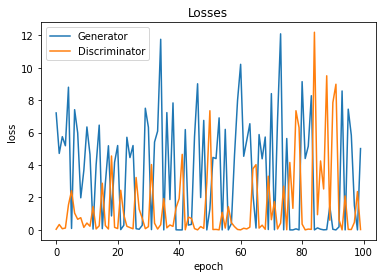

In [ ]:
plt.plot(metric_values[0][0],'-')
plt.plot(metric_values[0][3],'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Generator','Discriminator'])
plt.title('Losses')

Text(0.5, 1.0, 'Score')

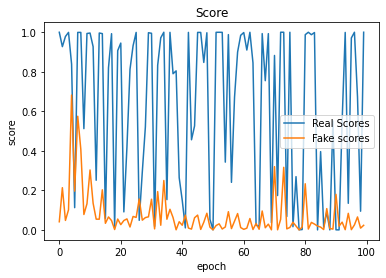

In [ ]:
plt.plot(metric_values[0][1],'-')
plt.plot(metric_values[0][2],'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Scores','Fake scores'])
plt.title('Score')

In [ ]:
metric_values[0][3]

In [ ]:
#IMAGE TRANSITION
from torch.autograd import Variable
import torchvision.utils as vutils
from __future__ import print_function
from PIL import Image
import random

In [ ]:
def convert_img(img_tensor, nrow):
    img_tensor = img_tensor.cpu()
    grid = vutils.make_grid(img_tensor, nrow=nrow, padding=2)
    ndarr = grid.mul(0.5).add(0.5).mul(255).byte().transpose(0, 2).transpose(0, 1).numpy()
    im = Image.fromarray(ndarr)
    return im

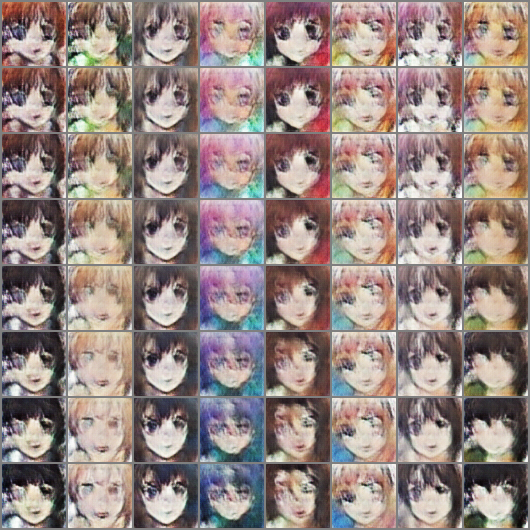

In [ ]:
a=torch.FloatTensor(8,128,1,1).normal_(0,1).to(device)
b=torch.FloatTensor(8,128,1,1).normal_(0,1).to(device)
ab=(b-a)/8.
c=torch.FloatTensor(64,128,1,1).to(device)
for i in range(8):
   c[8*i:8*(i+1),:,:,:] = a + i*ab
c=Variable(c)
c_out= generator(c)

c_im = convert_img(c_out.data,8)
c_im


In [ ]:
c=torch.FloatTensor(64,128,1,1).to(device)
c[9*1:9*(1+1)] = 1

In [ ]:
torch.Tensor(10,128,1,1).shape

torch.Size([10, 128, 1, 1])

In [ ]:


import numpy as np

from numpy import linspace
def interpolate(p1,p2,step=10):
  ratios=torch.linspace(0,2,steps=step)
  vec=torch.Tensor(10,128,1,1)
  i=0
  for ratio in ratios:
    #v = (1.0 - ratio) * p1 + ratio * p2
    m1=torch.mul(torch.sub(1.0,ratio), p1)
    m2=torch.mul(ratio,p2)
    add=torch.add(m1,m2)
    vec[i]=add.view(1,128,1,1)
    i=i+1
  return vec

In [ ]:
ratios=torch.linspace(0,1,steps=10)
vec=torch.Tensor(10,128,1,1)
points =torch.randn(2,latent_size)
for ratio in ratios:
  m1=torch.mul(torch.sub(1.0,ratio), points[0])
  m2=torch.mul(ratio,points[1])
  add=torch.add(m1,m2)
  vec[0]=add.view(1,128,1,1)
  print(add.shape)
  break

torch.Size([128])


In [ ]:
vec[0].shape

torch.Size([128, 1, 1])

In [ ]:
vec=torch.Tensor(10,128,1,1)
vec[0]=1
vec[1].shape


torch.Size([128, 1, 1])

In [ ]:
points[0].shape

torch.Size([128])

In [ ]:
inter_polated.shape

torch.Size([10, 128, 1, 1])

In [ ]:
latent_size=128
points =torch.randn(2,latent_size)
inter_polated = interpolate(points[0],points[1])
inter_polated=inter_polated#.to(device)
#out=generator(inter_polated)
#convert_img(out,10)

In [ ]:
points[1]

tensor([ 6.6637e-01, -7.4265e-02, -2.0960e-01,  1.6632e-01,  1.4703e+00,
        -9.3909e-01, -6.0132e-01, -9.9640e-02, -9.8515e-01, -2.4885e+00,
        -3.3132e-01,  8.4358e-01,  9.8745e-01, -3.3197e-01, -8.0762e-01,
         8.2436e-01,  2.4700e-02, -1.0641e+00, -7.6019e-01, -4.0751e-01,
         9.6236e-01, -1.4264e-01,  1.5271e-01, -3.8802e-02,  9.4461e-01,
        -1.5824e+00,  9.8713e-01,  1.1457e+00, -1.4181e-01, -2.7634e-01,
        -1.9321e-01,  7.7678e-01,  6.8388e-01, -1.3246e+00, -5.1608e-01,
         6.0018e-01, -4.7022e-01, -6.0864e-01, -4.6192e-02, -1.6457e+00,
        -4.8333e-01, -7.4029e-01,  3.1428e-01,  1.4156e-01,  1.0348e+00,
        -6.2644e-01, -5.1509e-01,  6.9029e-01, -4.9400e-01,  1.1366e+00,
        -4.6184e-01,  1.4200e+00,  8.4852e-01, -4.7891e-02,  6.6856e-01,
         1.0430e+00,  6.8990e-01, -1.3129e+00,  3.7804e-02, -1.1702e+00,
        -1.0319e-01,  1.1895e+00,  7.6069e-01, -7.4630e-01, -1.3839e+00,
         4.8687e-01, -1.0020e+00,  3.2949e-02, -4.2

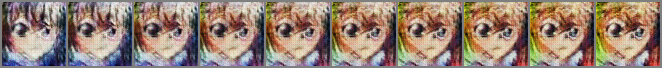

In [ ]:
import cv2
import os

frame = 'trainvid.avi'
file=[os.path.join(sample_dir,f) for  f in os.listdir(sample_dir) if 'generated' in f]
file.sort()

out=cv2.VideoWriter(frame,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in file]
out.release()

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr,epochs=epochs)

Text(0.5, 1.0, 'Losses')

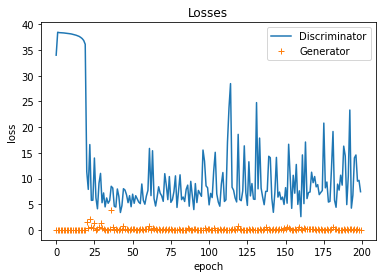

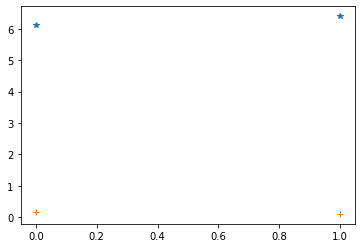

In [ ]:
plt.plot(metric_values[0][0],'*')
plt.plot(metric_values[0][3],'+')

In [ ]:
metric_values

[([6.117691993713379, 6.4015302658081055],
  [0.9402453899383545, 0.9664534330368042],
  [0.08382581174373627, 0.0639883279800415],
  [0.1614455282688141, 0.10539011657238007])]

SCRAPING


In [ ]:
import os
import shutil
import requests
from urllib.request import urlretrieve
from bs4 import BeautifulSoup
from skimage import io

In [ ]:
total_count = 0
root_url = 'https://myanimelist.net'
y_m_url = 'https://myanimelist.net/topanime.php?limit=0'

In [ ]:
root_dir = './images'
#shutil.rmtree(root_dir, ignore_errors=True)

In [ ]:
os.mkdir(root_dir)

In [ ]:
out_dir = os.path.join(root_dir, '1')
out_dir

'./images/1'

In [ ]:
for i in range(0,1000,50):
  y='https://myanimelist.net/topanime.php?limit={}'.format(i)
  print(y)

In [ ]:
##with name
c=0
for i in range(8000,10000,50):
    print('start',i)
    y_m_url='https://myanimelist.net/topmanga.php?limit={}'.format(i)
    response = requests.get(y_m_url)
    doc = BeautifulSoup(response.text)
    headpart=doc.find_all('td',class_="title al va-t clearfix word-break")
    print(len(headpart))
    o=0
    for link in headpart:
        o=o+1
        url=link.find('h3',class_='manga_h3')
        urlnext=url.find('a').attrs['href']
        pagenext = requests.get(urlnext)
        pagetext=BeautifulSoup(pagenext.text)
        imgurl=pagetext.find_all('a',class_="fw-n")
        #imgname=pagetext.find_all('h3',class_="h3_characters_voice_actors")
        length=len(imgname)
        l=0
        print('length',length,o)
        for imgpic in imgurl:
            try:
                img_tags = imgpic.find('img', attrs = { 'data-src': lambda x : x  and 'characters' in x})['data-srcset']
                if img_tags:
                    img_text=imgpic.find('img').attrs['alt'].strip()
                
                imgjpg=img_tags.split(',')[1].split('2x')[0]
                c=c+1
                l=l+1
                urlretrieve(imgjpg,os.path.join('./trial_images','{}.jpg'.format(img_text.split('/')[1] if '/' in img_text else img_text)))
            except TypeError:
                pass
    

start 0
50
start 50
50
start 100
50
start 150
50
start 200
50
start 250
50
start 300
50
start 350
50
start 400
50
start 450
50
start 500
50
start 550
50
start 600
50
start 650
50
start 700
50
start 750
50
start 800
50
start 850
50
start 900
50
start 950
50
start 1000
50
start 1050
50
start 1100
50
start 1150
50
start 1200
50
start 1250
50
start 1300
50
start 1350
50
start 1400
50
start 1450
50
start 1500
50
start 1550
50
start 1600
50
start 1650
50
start 1700
50
start 1750
50
start 1800
50
start 1850
50
start 1900
50
start 1950
50
start 2000
50
start 2050
50
start 2100
50
start 2150
50
start 2200
50


In [ ]:

def detect(filename, outname, cascade_file = "./lbpcascade_animeface.xml"):
    if not os.path.isfile(cascade_file):
        raise RuntimeError("%s: not found" % cascade_file)
    cascade = cv2.CascadeClassifier(cascade_file)
    image = cv2.imread(filename, cv2.IMREAD_COLOR)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    faces = cascade.detectMultiScale(gray,
                                    # detector options
                                    #scaleFactor =1.5,
                                    #minNeighbors = 5,
                                    minSize = (24, 24)
                                    )
    
    if len(faces)>0:
        x, y, w, h = faces[0]
        #print(x, y, w, h)
        cv2.imwrite(outname, image[int(y-0.0*h): int(y+0.9*h), x: x+w])
        return True
    else:
        return False
  
    


ct = 0
k=0
l=0
#os.mkdir('./cropped_3')
files = os.listdir('./images_with_name/')

for f in files:
    l=l+1
    if detect(os.path.join('./images_with_name/',f), './cropped_3/{}'.format(f)):
        ct=ct+1
        print(f)
        k=k+1
        


In [ ]:
import os
import re
path = "./images_with_name/"
files = os.listdir(path)
k=0
pattern = re.compile("[0-9]+")



  
#os.makdir('./image_1000_numbersname')
#print(f"Before Renaming: {files}")
for i in range(len(files)):
   ## if pattern.fullmatch(files[i].strip('.jpg')[0]):
        #shutil.move('./images_with_name/{}'.format(files[i]),'./image_extra_numbers/')
    os.rename(path+files[i], f"{path}{i}.jpg")
#print(f"After Renaming: {os.listdir(path)}")

In [ ]:

shutil.move('./images_with_name/23.jpg','./image_extra_numbers')

In [ ]:
c

In [ ]:
len(os.listdir('./images'))

9027

2738